# Đồ án Phân tích & Dự đoán Giá nhà

**Mục tiêu:**
1. Phân tích khám phá (EDA) bộ dữ liệu Ames Housing.
2. Tiền xử lý dữ liệu và xây dựng các pipeline xử lý.
3. So sánh 6 mô hình Machine Learning:
    - Linear Regression
    - Ridge Regression
    - Lasso Regression
    - SVM (SVR)
    - Random Forest Regressor
    - XGBoost Regressor
4. Tìm ra mô hình tốt nhất, tinh chỉnh và phân tích các đặc trưng quan trọng.
5. Lưu mô hình tốt nhất vào file `.joblib` để triển khai web app.

## 1. 🛠️ Khởi tạo (Setup)

Tải tất cả các thư viện cần thiết cho dự án:

In [9]:
# === Thư viện Cốt lõi (Core Libraries) ===
import pandas as pd
import numpy as np

# === Trực quan hóa (Visualization) ===
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Dùng cho Q-Q plot và kiểm tra độ lệch (skewness)

# === Tiền xử lý (Preprocessing) - scikit-learn ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# === Mô hình (Models) - scikit-learn ===
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# === Mô hình (Models) - Bên ngoài ===
from xgboost import XGBRegressor # Mô hình XGBoost

# === Đánh giá (Evaluation) - scikit-learn ===
from sklearn.metrics import mean_squared_error, r2_score

# === Tiện ích (Utils) ===
import joblib # Dùng để lưu và tải mô hình
import warnings # Dùng để tắt các cảnh báo không cần thiết

# === Cài đặt cho Notebook ===
# Đặt style chung cho các biểu đồ
plt.style.use('ggplot')
# Hiển thị biểu đồ ngay trong notebook
%matplotlib inline
# Tắt các cảnh báo (optional)
warnings.filterwarnings('ignore')

print("Tất cả thư viện đã được tải thành công.")

Tất cả thư viện đã được tải thành công.


## 2. 💾 Tải Dữ liệu (Load Data)

Đọc dữ liệu từ thư mục `data/`. Chúng ta sẽ thực hiện tất cả phân tích và
huấn luyện trên `train.csv`.

In [10]:
# Đặt đường dẫn file
DATA_DIR = '../data/'
TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'test.csv'
DATA_DESC_FILE = DATA_DIR + 'data_description.txt'

# Tải dữ liệu huấn luyện
try:
    df_train = pd.read_csv(TRAIN_FILE)
    print("Tải file train.csv thành công.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại {TRAIN_FILE}")
    print("Hãy đảm bảo file train.csv nằm trong thư mục data/")

Tải file train.csv thành công.


In [11]:
# Hiển thị 5 dòng đầu tiên
print(f"Hình dạng của dữ liệu (Hàng, Cột): {df_train.shape}")
df_train.head()

Hình dạng của dữ liệu (Hàng, Cột): (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
# Kiểm tra thông tin các cột (kiểu dữ liệu, số lượng non-null)
# Đây là bước quan trọng để chuẩn bị cho việc xử lý giá trị thiếu (Missing Values)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 3. 📊 Phân tích Khám phá & Tiền xử lý (EDA & Preprocessing)

### 3.1. Phân tích Biến mục tiêu (`SalePrice`)

Biến mục tiêu của chúng ta là `SalePrice`. Chúng ta cần kiểm tra phân phối của nó để xem nó có bị lệch (skewed) hay không.

Text(0, 0.5, 'Tần suất (Frequency)')

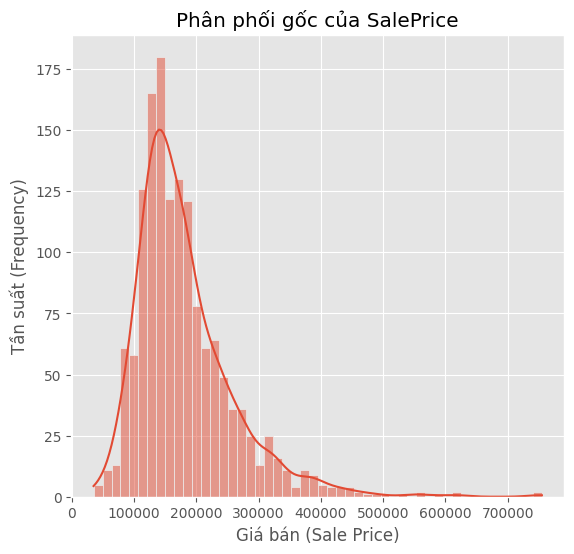

In [13]:
# Đặt kích thước biểu đồ
plt.figure(figsize=(14, 6))

# Vẽ biểu đồ Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_train['SalePrice'], kde=True, bins=50)
plt.title('Phân phối gốc của SalePrice')
plt.xlabel('Giá bán (Sale Price)')
plt.ylabel('Tần suất (Frequency)')



> **Nhận xét (từ Histogram):** Biểu đồ rõ ràng bị **lệch phải
(right-skewed)**. Hầu hết các nhà có giá trị thấp đến trung bình, và có một
"đuôi" dài gồm các căn nhà rất đắt (giá trị ngoại lệ).

Độ lệch (Skewness) của SalePrice: 1.8829


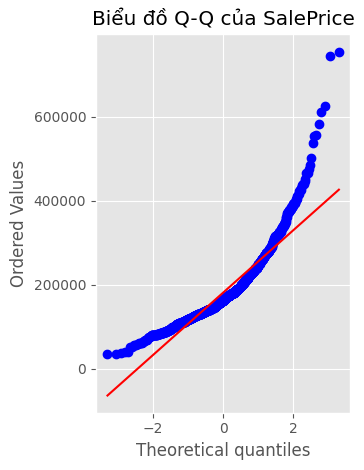

In [14]:
# Tính toán độ lệch (Skewness)
skewness = df_train['SalePrice'].skew()
print(f"Độ lệch (Skewness) của SalePrice: {skewness:.4f}")

# Vẽ biểu đồ Q-Q (Quantile-Quantile)
plt.subplot(1, 2, 2)
stats.probplot(df_train['SalePrice'], plot=plt)
plt.title('Biểu đồ Q-Q của SalePrice')

plt.tight_layout()
plt.show()



> **Nhận xét (từ Skewness & Q-Q Plot):**
> * **Độ lệch (Skewness):** Giá trị ~1.88 (lớn hơn 1) xác nhận mức độ lệch phải là đáng kể.
> * **Biểu đồ Q-Q:** Các điểm dữ liệu (màu xanh) không nằm trên đường chéo màu đỏ. Chúng bị uốn cong ở phần đuôi trên, xác nhận rằng dữ liệu không tuân theo phân phối chuẩn.

### Giải pháp: Biến đổi Logarit (Log Transformation)

Để khắc phục độ lệch này, chúng ta sẽ áp dụng phép biến đổi logarit. Chúng ta sẽ sử dụng `np.log1p` (tương đương với `log(1 + x)`) để xử lý an toàn mọi giá trị bằng 0 (mặc dù ở đây giá nhà không bằng 0).

Chúng ta sẽ tạo một cột mới `SalePrice_Log` và dùng nó làm biến mục tiêu mới.

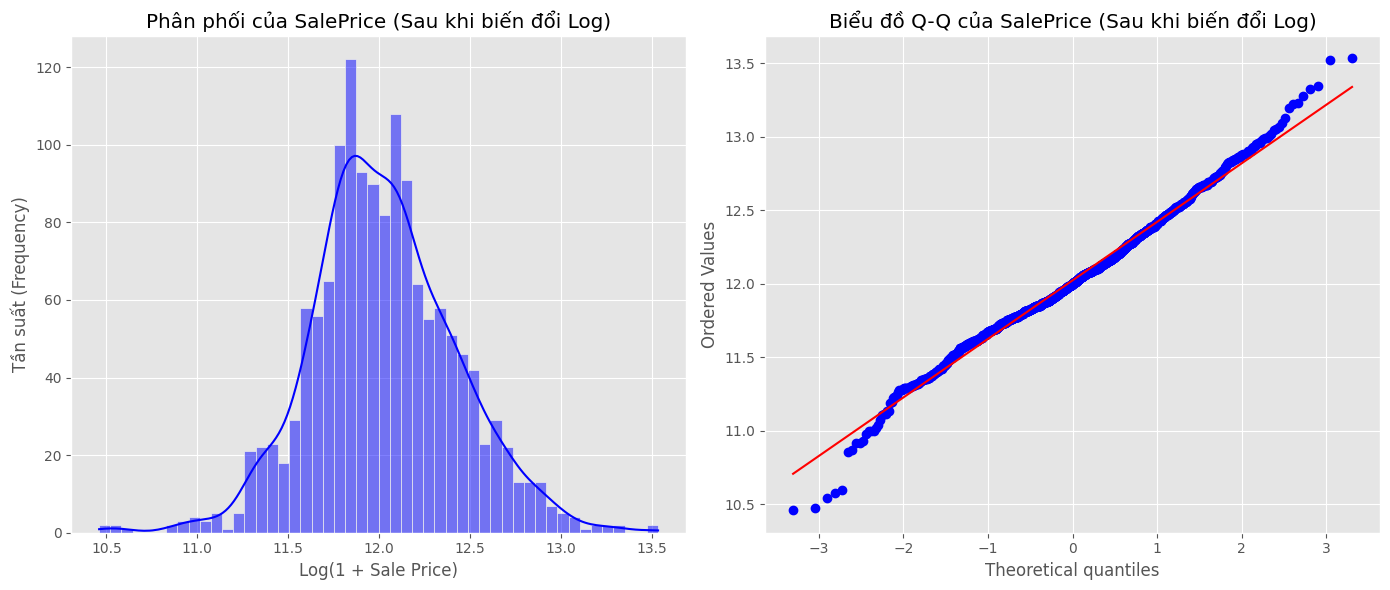

In [15]:
# Áp dụng phép biến đổi log1p
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice'])

# Vẽ lại biểu đồ cho cột mới
plt.figure(figsize=(14, 6))

# Biểu đồ Histogram mới
plt.subplot(1, 2, 1)
sns.histplot(df_train['SalePrice_Log'], kde=True, bins=50, color='blue')
plt.title('Phân phối của SalePrice (Sau khi biến đổi Log)')
plt.xlabel('Log(1 + Sale Price)')
plt.ylabel('Tần suất (Frequency)')

# Biểu đồ Q-Q mới
plt.subplot(1, 2, 2)
stats.probplot(df_train['SalePrice_Log'], plot=plt)
plt.title('Biểu đồ Q-Q của SalePrice (Sau khi biến đổi Log)')

plt.tight_layout()
plt.show()

In [16]:
# Kiểm tra lại độ lệch mới
new_skewness = df_train['SalePrice_Log'].skew()
print(f"Độ lệch (Skewness) MỚI của SalePrice_Log: {new_skewness:.4f}")

Độ lệch (Skewness) MỚI của SalePrice_Log: 0.1213


> **Kết luận:** Thành công!
> * Độ lệch mới bây giờ rất gần 0 (~0.12).
> * Biểu đồ phân phối trông gần như hình chuông (phân phối chuẩn).
> * Biểu đồ Q-Q cho thấy các điểm dữ liệu bây giờ nằm gần như thẳng hàng trên đường chéo màu đỏ.
>
> **Từ giờ trở đi, chúng ta sẽ huấn luyện tất cả các mô hình để dự đoán `SalePrice_Log`.**

### 3.2. Phân tích Tương quan Đặc trưng (Feature Correlation)

### 3.3. Xử lý Giá trị bị thiếu (Missing Values)

### 3.4. Kỹ thuật Đặc trưng (Feature Engineering)

## 4. ⚙️ Xây dựng Pipeline & Huấn luyện Mô hình

### 4.1. Phân chia Dữ liệu (Train/Test Split)

### 4.2. Định nghĩa Pipeline Tiền xử lý

### 4.3. So sánh 6 Mô hình

### 4.4. Hiển thị Bảng so sánh Kết quả

## 5. 🏆 Tinh chỉnh & Phân tích Mô hình Tốt nhất

### 5.1. Phân tích Tầm quan trọng Đặc trưng (Feature Importance)

## 6. 📈 Phân tích Bổ sung (Chuỗi thời gian)

## 7. 🚀 Lưu Mô hình